# Automatic differentiation: a backpropagation example for genetic programming

The purpose of this notebook is to demonstrate how weights can be learned for programs made up of differentiable nodes. In this case we're concerned with stack-based representations of mathematical functions, such as 

[ x1 x2 + sin ] $\rightarrow sin(x1+x2)$

or with embedded weights, $w_4 \cdot \sin( w_3 \cdot ( w_1 \cdot x_1 + w_2 \cdot x_2) ) $

In [178]:
# define node classes
# Need to figure out how to work in batch gradient descent, problem with variables not knowing their value
# Might want to consider changing implementation to using a "counter/pointer" instead of using the bp_stack
# need to integrate cost function

# Implement a softmax node - compare against tensorflow (simple NN, logit, tanh, softmax)
# bush to backprop
# Deal with elements that aren't differentiable (keep executing branch but skip past that value)
# How to breakup cost function - cost evaluated and stored for the program might not be the 

# keep in mind parallel ability for future implementations (in terms of nodes)

# Need separate copies for separate weights
class Variable():
    def __init__(self,loc=0):
        self.loc = loc
        self.name='x_'+str(loc)
        self.arity=0
        self.visits=0
                
    def evaluate(self,stack,X=None):
        stack.append(X[:,self.loc])
    
class Add():
    def __init__(self, W=None):
        self.name='+'
        self.arity=2
        self.visits=0
        
        # Technically have vulnerability to lists of non numbers
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(self.W[0]*stack.pop() + self.W[1]*stack.pop())
        
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
            
        if loc == 0:
            stack.append(self.W[1]*fwd_stack[-1]+ + self.W[0]) # Reset -1 to -2
        else:
            stack.append(self.W[0]*fwd_stack[-1] + self.W[1])
        
    def update(self,derivatives,fwd_stack,n,loc):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value) # assuming np.array
        print("Add updating with", (n/update_value.size * sum(update_value)))
        
class Subtract():
    def __init__(self,W=None):
        self.name='-'
        self.arity=2
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
        
    def evaluate(self,stack,X=None):
        stack.append(self.W[0]*stack.pop() - self.W[1]*stack.pop())
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        if loc == 0: # D wrt first value
            stack.append(self.W[0] - self.W[1] * fwd_stack[-2])
        else: # wrt second value
            stack.append(self.W[0] * fwd_stack[-1] - self.W[2])
        
    def update(self,derivatives,fwd_stack,n,loc):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)
        
class Multiply():
    def __init__(self,W=None):
        self.name='*'
        self.arity=2
        self.error=0
        self.visits=0
        
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(self.W[0] * stack.pop() * self.W[1] * stack.pop())
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(self.W[0] * self.W[1] * fwd_stack[-(loc + 1)]) 
        
    def update(self,derivatives,fwd_stack,n,loc):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)

class Divide():
    def __init__(self,W=None):
        self.name='/'
        self.arity=2
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0, 1.0]
 
    def evaluate(self,X,stack):
        stack.append((self.W[0] * stack.pop())/(self.W[1] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
            
        if loc==0:
            stack.append(1/(self.W[loc] *fwd_stack[-2])) # first value would have been numerator
        else:
            stack.append(-self.W[loc-1] * fwd_stack[-1]/(self.W[loc] * fwd_stack[2]^2))
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)
 
class Sin():
    def __init__(self,W=None):
        self.name='sin'
        self.arity=1
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
        
    def evaluate(self,stack,X=None):
        stack.append(np.sin(self.W[0] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(self.W[loc] * np.cos(self.W[loc] * fwd_stack[-1]))
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        print("Sin updating with", (n/update_value.size * sum(update_value)))
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)
        
class Cos():
    def __init__(self,W=None):
        self.name='cos'
        self.arity=1
        self.error=0
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(np.cos(self.W[0] * stack.pop()))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(-self.W[loc] * np.sin(self.W[loc] * fwd_stack[-1])) 
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)
        print("Cos updating with", (n/update_value.size * sum(update_value)))
        
class logit():
    def __init__(self,W=None):
        self.name='logit'
        self.arity=1
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        stack.append(1/(1+exp(-self.W[0] * stack.pop())))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(self.evaluate([fwd_stack[-1]]) *(1-self.evaluate([fwd_stack[-1]])))
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)
      
# How do we deal with multiple outputs in the context of the program?
class softmax(): # Vector operating node - takes in multiple inputs, produces multiple outputs
    def __init__(self,W=None, arity=2):
        self.name='softmax'
        self.arity=arity
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0 for x in range(len(arity))]
            
    # Take off the top n values from the stack and add n values to the stack
    def evaluate(self,stack,X=None):
        values = [math.exp(stack.pop()) for i in range(self.arity)]
        
        sum = 0
        for value in values:
            denom += values
        
        for value in values:
            stack.append(value/denom)
    
    # Take off top n values from the stack and compute the n x n matrix of derivatives?
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(self.evaluate([fwd_stack[-1]]) *(1-self.evaluate([fwd_stack[-1]])))
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)
        
class tanh():
    def __init__(self,W=None):
        self.name='tanh'
        self.arity=1
        self.visits=0
        if isinstance(W, list) and len(W) == self.arity: self.W = W
        else: self.W = [1.0]
            
    def evaluate(self,stack,X=None):
        z = self.W[0] * stack.pop();
        stack.append((np.exp(z) - np.exp(-z))/(np.exp(z) + np.exp(-z)))
    
    def derivative(self,stack,fwd_stack,loc=0):
        if loc > self.arity:
            loc = 0
        stack.append(1 - self.evaluate([fwd_stack[-1]])**2)
        
    def update(self,derivatives,fwd_stack,n,loc=0):
        update_value = 1;
        for d in derivatives:
            update_value *= d;
        
        update_value *= fwd_stack[-1]
        self.W[loc] = self.W[loc] - n/update_value.size * sum(update_value)

In [179]:
# Cost Functions
class CostSquaredDifference():
    def __init__(self,labels=None):
        self.visits=0
        self.arity=2
        self.name="Squared Error Cost"
        try: 
            _ = labels.shape
            self.arity=1
            self.labels=labels
        except:
            self.labels=labels
        
    def set_labels(self, labels):
        try: 
            _ = labels.shape
            self.arity=1
        except:
            self.labels=None
            self.arity=2
    
    def evaluate(self,Y_hat,Y=None):
        try: 
            result = (Y_hat - Y)**2
        except:
            result = (Y_hat - self.labels)**2
            
        return result
    
    def derivative(self,Y_hat,Y=None):
        try: 
            result = 2*(Y_hat - Y)
        except:
            result = 2*(Y_hat - self.labels)
        return result
    
    def update(self,derivative,fwd_stack,n,loc):
        pass    

In [180]:
import copy

class Auto_backprop():
    def __init__(self, program, cost_fcn, X, labels, iters=1000, n=0.1):
        self.program = program    # Program to modify (stack)
        self.cost_fcn = cost_fcn  # Determines how error is calculated (expected args are y_hat, y)
        self.X = X                # Training data (list of values)
        self.labels = labels      # Training labels (list of values)
        self.iters = iters        # Iterations of learning (scalar)
        self.n = n                # Learning Rate (scalar)
        
    def start(self):
        # "Intialize" cost function
        self.cost_fcn.set_labels(self.labels)
        
        # Computes weights via backprop
        for x in range(self.iters):            
            fwd_stack = self.forward_prop()
            if (x % 1) == 0:
                print("Currently on iter: " + str(x))
                print("Error: " + str(sum(self.cost_fcn.evaluate(fwd_stack[-1]))))
            self.backprop(fwd_stack)
            
        print("Gradient Descent Complete ------------------------------")
        # print("Error: " + str(sum(self.cost_fcn.evaluate(fwd_stack[-1]))))
        return self.program
        
    def forward_prop(self):
        # Computes the forward pass of the program as described by the stack
        execution_stack = []
        fwd_stack = []
        
        # Program stack itself is unchanging
        for p in self.program:
            p.visits=0 # Clear our values set by backprop
            
            # Keep track of what computations were needed for execution (for purpose of GD)
            for x in range(p.arity):
                fwd_stack.append(execution_stack[-(x + 1)])
                
            p.evaluate(execution_stack, self.X)
            
            # Need to keep track of computations before they are consumed
            #fwd_stack.append(execution_stack[-1])
        
        return fwd_stack
        
    def backprop(self, fwd_stack):
        # calculates the gradients of the program for propagating error
        # Prepare stacks
        gradients = [self.cost_fcn.derivative(fwd_stack[-1])]
        print("Starting with cost: ", gradients[-1])
        executing = []
        bp_program = copy.copy(self.program) # Using a counter approach would allow avoiding this

        while bp_program:
            node = bp_program.pop() 
            if node.visits == 0:
                if node.arity > 0:
                    node.derivative(gradients, fwd_stack) # Add deritivative to stack
            
            if node.arity == 0:
                # Must be a variable pop parent operator back on if there is one
                if executing:
                    bp_program.append(executing.pop())
            else:
                # Must be an operator
                node.visits += 1
                
                node.update(gradients,fwd_stack,self.n, node.arity - node.visits) # Might need to adjust to be orginal arity - current
                if node.visits < node.arity:
                    executing.append(node)
                else:
                    # Operator branches have been completely explored, remove all traces of it
                    gradients.pop()
                    
                    # Put parent back on program stack
                    if executing:
                        bp_program.append(executing.pop())

Error before GD: 6.196718078216731
Currently on iter: 0
Error: 6.196718078216731
('Starting with cost: ', array([-0.5979546 , -0.60591301, -0.60277107, -0.58856188, -0.56343837,
       -0.5276835 , -0.48172635, -0.4261607 , -0.36176224, -0.28949992,
       -0.21053753, -0.12622282, -0.03806275,  0.05231448,  0.14320817,
        0.23290038,  0.31971303,  0.40206105,  0.47849727,  0.54774528,
        0.6087186 ,  0.66052635,  0.70246733,  0.73401582,  0.75480332,
        0.76460051,  0.76330316,  0.75092493,  0.72759834,  0.69358376,
        0.64928472,  0.59526637,  0.5322732 ,  0.46124163,  0.38330348,
        0.2997773 ,  0.21214589,  0.12202043,  0.03109331, -0.05891645,
       -0.14632027, -0.22951426, -0.30702572, -0.37754817, -0.43996284,
       -0.4933465 , -0.53696723, -0.5702714 , -0.5928657 , -0.60449881,
       -0.60504643, -0.5945028 , -0.57298027, -0.54071706, -0.49809169,
       -0.44564115, -0.38407909, -0.31430952, -0.23743205, -0.15473538,
       -0.06767718,  0.0221496

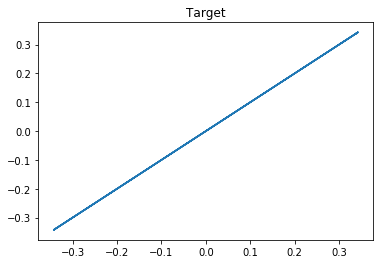

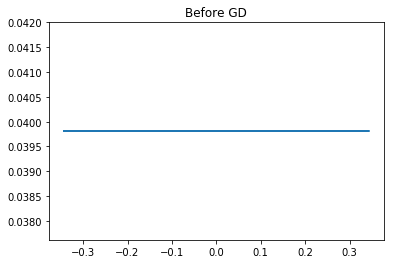

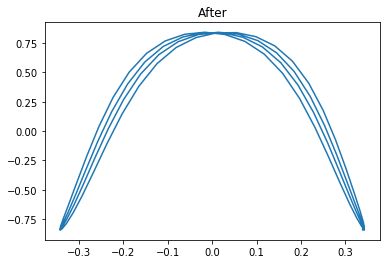

In [181]:
import numpy as np
import matplotlib.pyplot as plt
# X = np.random.rand(100,2)
data1 = np.asarray([1.0 * i for i in range(100)])
data2 = np.flip(data1, 0)
X = np.stack((data1, data2), -1)
# test weights
w1, w2, w3 = 0.35, 0.76, 0.89

# Attempt backpropagation
ytest = np.sin(w1*np.cos(w3*X[:,0] + w2 * X[:,1]))
prog = [Variable(loc=0), Variable(loc=1), Add(), Cos(), Sin()]
for p in prog:
    p.evaluate(stack, X)
yhat2 = np.array(stack[-1])

cost_fcn = CostSquaredDifference(ytest)
error = cost_fcn.evaluate(yhat2)
print('Error before GD: ' + str(sum(error)))

GD = Auto_backprop(prog, cost_fcn, X, ytest, 1)
prog = GD.start()
for p in prog:
    p.evaluate(stack, X)
yhat3 = np.array(stack[-1])
error = cost_fcn.evaluate(yhat3)
print('Error after GD: ' + str(sum(error)))

h0 = plt.figure()
plt.plot(ytest,ytest)
plt.title('Target')
plt.show()

h1 = plt.figure()
plt.plot(ytest,yhat2)
plt.title('Before GD')
plt.show()

h2 = plt.figure()
plt.plot(ytest,yhat3)
plt.title('After')
plt.show()
